In [568]:
import numpy as np
import matplotlib.pyplot as plt
import pyasdf
import obspy
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel

%matplotlib inline

model = TauPyModel(model="ak135")

In [569]:
net_sta="BO.WJM"

In [570]:
from obspy.signal.util import _npts2nfft
def sync_remove_response(pre_filt, st):
    """
    mimic obspy.remove_response, but only do the frequency taper
    """
    obspy.core.util.misc.limit_numpy_fft_cache()
    for trace in st:
        data = trace.data.astype(np.float64)
        npts = len(data)
        nfft = _npts2nfft(npts)
        data = np.fft.rfft(data, n=nfft)
        t_samp = trace.stats.delta
        fy = 1 / (t_samp * 2.0)
        freqs = np.linspace(0, fy, nfft // 2 + 1).astype(np.float64)
        freq_domain_taper = obspy.signal.invsim.cosine_sac_taper(
            freqs, flimit=pre_filt)
        data *= freq_domain_taper
        data = np.fft.irfft(data)[0:npts]
        trace.data = data

    return st


In [571]:
data=pyasdf.ASDFDataSet("/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.data.h5",mode="r")
sync_old=pyasdf.ASDFDataSet("/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.sync_old.h5",mode="r")

In [572]:
sync_old

ASDF file [format version: 1.0.2]: '../../data/asdf_files/compare_data_processing/201105101526A.sync_old.h5' (577.0 MB)
	Contains 1 event(s)
	Contains waveform data from 1962 station(s).

In [573]:
event = data.events[0]
origin = event.preferred_origin() or event.origins[0]
event_time = origin.time
event_latitude = origin.latitude
event_longitude = origin.longitude
event_depth=origin.depth

In [574]:
BO_WJM=data.waveforms[net_sta].raw.copy()
BO_WJM_sync=sync_old.waveforms[net_sta].sync.copy()

In [575]:
BO_WJM_sync[1].write("/Users/ziyixi/work/Japan_Slab_code/data/201105101526A_problem_related/BO.WJM/sync_old.MXT.sac",format="SAC")

In [576]:
event_time,BO_WJM,BO_WJM_sync

(2011-05-10T15:26:08.780000Z,
 3 Trace(s) in Stream:
BO.WJM..BHE | 2011-05-10T15:24:08.000000Z - 2011-05-10T16:06:07.950000Z | 20.0 Hz, 50400 samples
BO.WJM..BHN | 2011-05-10T15:24:08.000000Z - 2011-05-10T16:06:07.950000Z | 20.0 Hz, 50400 samples
BO.WJM..BHZ | 2011-05-10T15:24:08.000000Z - 2011-05-10T16:06:07.950000Z | 20.0 Hz, 50400 samples,
 3 Trace(s) in Stream:
BO.WJM.S3.MXR | 2011-05-10T15:26:06.229000Z - 2011-05-10T16:11:17.359578Z | 9.2 Hz, 24900 samples
BO.WJM.S3.MXT | 2011-05-10T15:26:06.229000Z - 2011-05-10T16:11:17.359578Z | 9.2 Hz, 24900 samples
BO.WJM.S3.MXZ | 2011-05-10T15:26:06.229000Z - 2011-05-10T16:11:17.359578Z | 9.2 Hz, 24900 samples)

In [577]:
BO_WJM.trim(event_time,event_time+1800)
BO_WJM_sync.trim(event_time,event_time+1800)

3 Trace(s) in Stream:
BO.WJM.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
BO.WJM.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
BO.WJM.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples

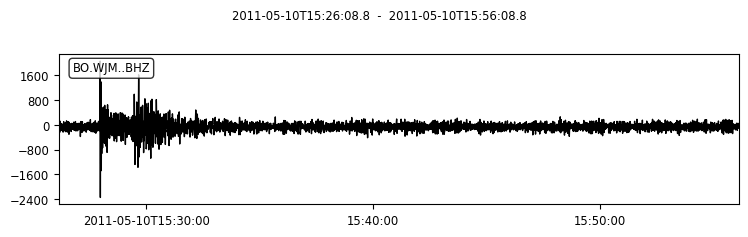

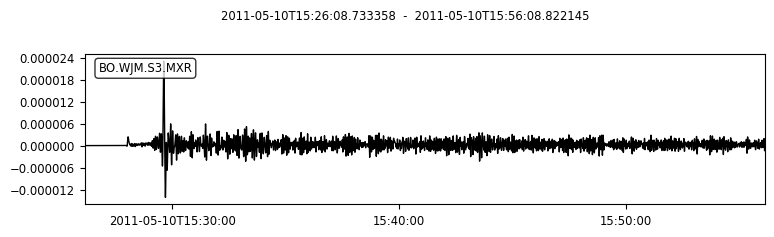

In [578]:
BO_WJM[2].plot();
BO_WJM_sync[0].plot();

In [579]:
BO_WJM.detrend("demean")
BO_WJM.detrend("linear")
BO_WJM.taper(max_percentage=0.05,type="hann")

3 Trace(s) in Stream:
BO.WJM..BHE | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 20.0 Hz, 36001 samples
BO.WJM..BHN | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 20.0 Hz, 36001 samples
BO.WJM..BHZ | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 20.0 Hz, 36001 samples

In [580]:
BO_WJM_sync.detrend("demean")
BO_WJM_sync.detrend("linear")
BO_WJM_sync.taper(max_percentage=0.05,type="hann")

3 Trace(s) in Stream:
BO.WJM.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
BO.WJM.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
BO.WJM.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples

In [581]:
inv=data.waveforms[net_sta].StationXML

In [582]:
max_period=100
min_period=10
f2 = 1.0 / max_period
f3 = 1.0 / min_period
f1 = 0.5 * f2
f4 = 2.0 * f3
pre_filt = (f1, f2, f3, f4)

In [583]:
# bk BO_WJM_sync
BO_WJM_sync_bk=BO_WJM_sync.copy()

In [584]:
BO_WJM.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
BO_WJM_sync=sync_remove_response(pre_filt, BO_WJM_sync)

In [585]:
BO_WJM.interpolate(sampling_rate=10)
BO_WJM_sync.interpolate(sampling_rate=10)

3 Trace(s) in Stream:
BO.WJM.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.WJM.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.WJM.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples

In [586]:
station_latitude = inv[0][0].latitude
station_longitude = inv[0][0].longitude
gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                         event_latitude, event_longitude)
baz = np.mod(baz, 360)
BO_WJM.rotate(method="NE->RT", back_azimuth=baz)

3 Trace(s) in Stream:
BO.WJM..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 10.0 Hz, 18001 samples
BO.WJM..BHR | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 10.0 Hz, 18001 samples
BO.WJM..BHZ | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 10.0 Hz, 18001 samples

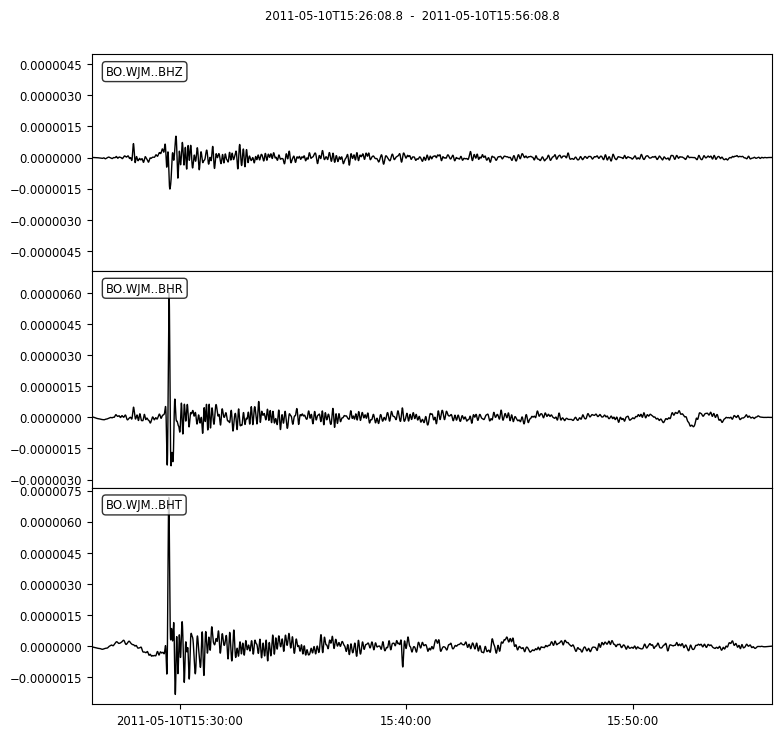

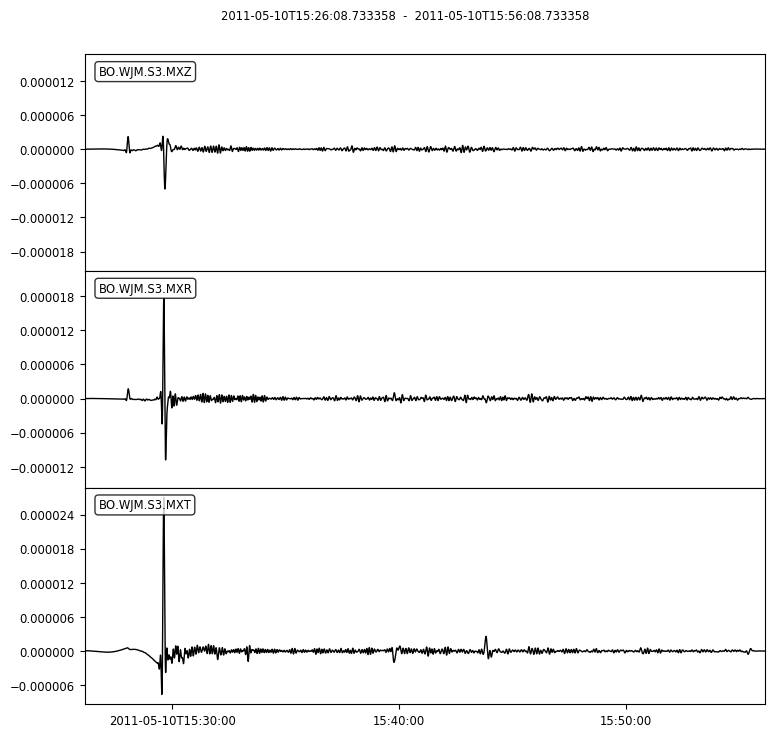

In [587]:
BO_WJM.plot();
BO_WJM_sync.plot();

In [588]:
BO_WJM.detrend("demean")
BO_WJM.detrend("linear")
BO_WJM.taper(max_percentage=0.05,type="hann")
BO_WJM_sync.detrend("demean")
BO_WJM_sync.detrend("linear")
BO_WJM_sync.taper(max_percentage=0.05,type="hann")

3 Trace(s) in Stream:
BO.WJM.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.WJM.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.WJM.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples

In [589]:
BO_WJM.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
BO_WJM_sync.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)

3 Trace(s) in Stream:
BO.WJM.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.WJM.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.WJM.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples

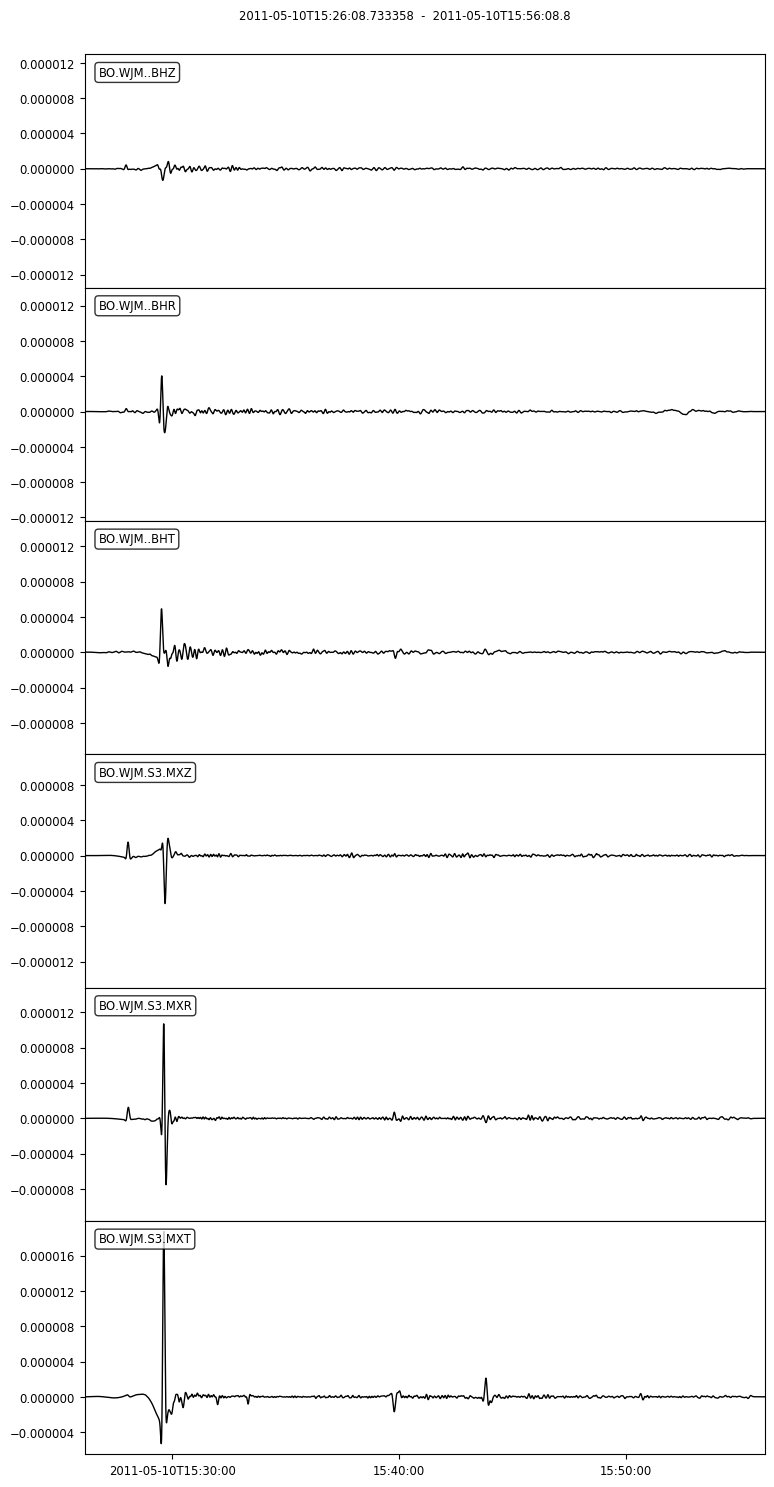

In [590]:
(BO_WJM+BO_WJM_sync).plot();

In [553]:
to_plot_sync=BO_WJM_sync[2].slice(BO_WJM_sync[2].stats.starttime+236.951-50,BO_WJM_sync[2].stats.starttime+236.951+70)
data_sync=to_plot_sync.data
to_plot=BO_WJM[0].slice(BO_WJM[0].stats.starttime+236.951-50,BO_WJM[0].stats.starttime+236.951+70)
data=to_plot.data
x=np.linspace(0,to_plot.stats.endtime-to_plot.stats.starttime,to_plot.stats.npts)

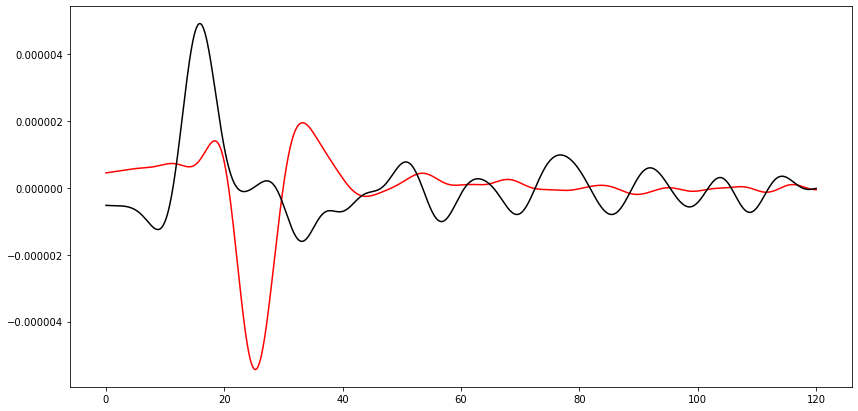

In [554]:
plt.figure(figsize=(14,7))
plt.plot(x,data_sync,color="r")
plt.plot(x,data,color="k")

In [435]:
BO_WJM_sync[2].stats.starttime

2011-05-10T15:26:08.730632Z

In [256]:
BO_WJM[0].stats.starttime

2011-05-10T15:26:08.800000Z

In [257]:
event_time

2011-05-10T15:26:08.780000Z

In [258]:
to_plot

BO.KNM..BHT | 2011-05-10T15:29:15.800000Z - 2011-05-10T15:31:15.800000Z | 10.0 Hz, 1201 samples

In [259]:
arrivals = model.get_travel_times(source_depth_in_km=event_depth/1000,
                                  distance_in_degree=kilometer2degrees(gcarc_m/1000),
                                  phase_list=["S","s"])

/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/pyasdf/asdf_data_set.py:52: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  closure_warn(self, *args, **kwargs)


In [260]:
for i in arrivals:
    print(i)

s phase arrival at 236.951 seconds


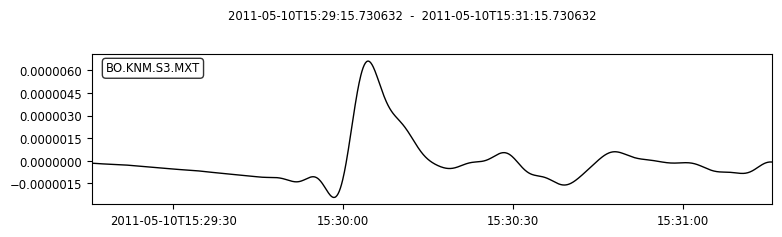

In [261]:
to_plot_sync.plot();

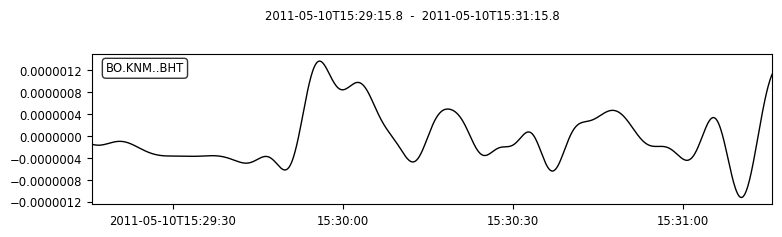

In [262]:
to_plot.plot();

In [264]:
to_plot_sync

BO.KNM.S3.MXT | 2011-05-10T15:29:15.730632Z - 2011-05-10T15:31:15.730632Z | 10.0 Hz, 1201 samples

# test sac

In [402]:
sacs=obspy.read("/Users/ziyixi/work/Japan_Slab_code/data/201105101526A_problem_related/BO.WJM/BO.WJM..BH*")

In [403]:
station_latitude = inv[0][0].latitude
station_longitude = inv[0][0].longitude
gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                         event_latitude, event_longitude)
baz = np.mod(baz, 360)
sacs.rotate(method="NE->RT", back_azimuth=baz)
sacs.interpolate(sampling_rate=10)

3 Trace(s) in Stream:
BO.WJM..BHT | 2011-05-10T15:24:08.000000Z - 2011-05-10T16:06:07.900000Z | 10.0 Hz, 25200 samples
BO.WJM..BHR | 2011-05-10T15:24:08.000000Z - 2011-05-10T16:06:07.900000Z | 10.0 Hz, 25200 samples
BO.WJM..BHZ | 2011-05-10T15:24:08.000000Z - 2011-05-10T16:06:07.900000Z | 10.0 Hz, 25200 samples

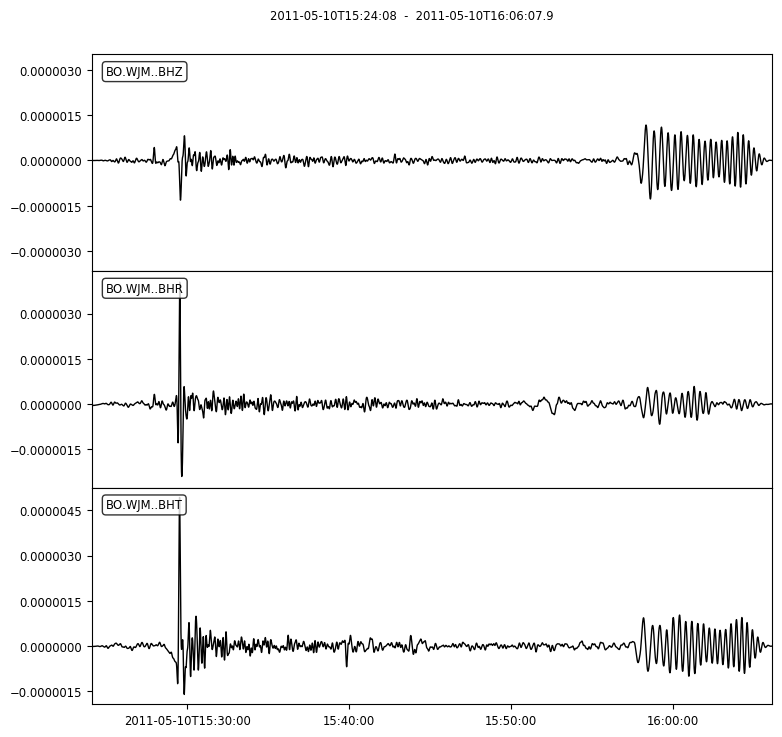

In [404]:
sacs.plot();

In [405]:
to_plot_sac=sacs[0].slice(event_time+138.95810139336427+20,event_time+138.95810139336427+140)
x=np.linspace(20,to_plot_sac.stats.endtime-to_plot_sac.stats.starttime+20,to_plot_sac.stats.npts)
data_sac=to_plot_sac.data

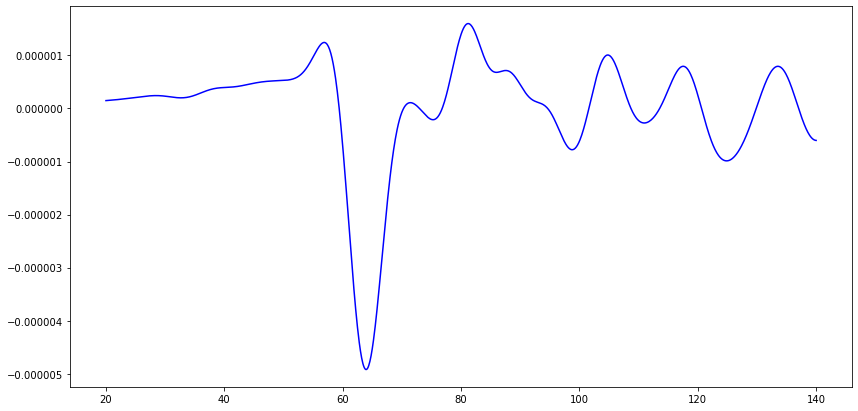

In [406]:
plt.figure(figsize=(14,7))
# plt.plot(x,data_sync,color="r")
plt.plot(x,-1*data_sac,color="b")
# plt.plot(x,data,color="k")

In [407]:
kilometer2degrees(gcarc_m/1000)*18

138.95810139336427

In [409]:
to_plot_sync=BO_WJM_sync[2].slice(event_time+138.95810139336427+20,event_time+138.95810139336427+140)
data_sync=to_plot_sync.data

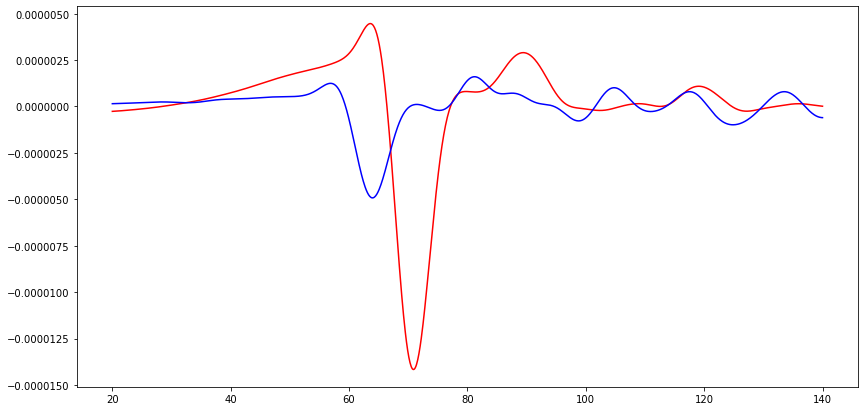

In [410]:
plt.figure(figsize=(14,7))
plt.plot(x,-1*data_sync,color="r")
plt.plot(x,-1*data_sac,color="b")
# plt.plot(x,data,color="k")